In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import h5py
import scipy.stats as stats

from density_profile_utils import calculate_rho_s, calculate_r_s, calculate_M200, calculate_R200, NFW_profile, mass, rho_mean, calculate_error_NFW_rho
from density_pericenter_fit_utils import run_best_fit, log_model
from density_pericenter_fit_utils import run_best_fit_for_sim
from density_pericenter_fit_utils import run_best_fit_for_sim_with_mcmc
from satellite_properties_plot_utils import plot_median_relation


plt.style.use("pltstyle.mplstyle")

## Get observational data

In [2]:
GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

Vmax = Kaplinghat_data[:,2]
le_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,3]
he_Vmax = Kaplinghat_data[:,2] + Kaplinghat_data[:,4]
NFW_Vmax = 10**Vmax[::2] # Only NFW fit data; [km/s] units
le_NFW_Vmax = NFW_Vmax - 10**le_Vmax[::2] # Only NFW fit data; [km/s] units
he_NFW_Vmax = 10**he_Vmax[::2] - NFW_Vmax # Only NFW fit data; [km/s] units

Rmax = Kaplinghat_data[:,5]
le_Rmax = Kaplinghat_data[:,6] + Kaplinghat_data[:,5]
he_Rmax = Kaplinghat_data[:,7] + Kaplinghat_data[:,5]
NFW_Rmax = 10**Rmax[::2] # Only NFW fit data; [kpc] units
le_NFW_Rmax = NFW_Rmax - 10**le_Rmax[::2]  # Only NFW fit data; [kpc] units
he_NFW_Rmax = 10**he_Rmax[::2] - NFW_Rmax  # Only NFW fit data; [kpc] units
he_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2
le_NFW_Rmax /= 2 # Reducing uncertainty in Rmax by factor of 2

num_satellites = len(NFW_Rmax)
M200_K19 = np.zeros((3,num_satellites))
R200_K19 = np.zeros((3,num_satellites))

rho_s = np.zeros(num_satellites)
r_s = np.zeros(num_satellites)
r_range = np.arange(-4, 4, 0.01) # Some radial range
r_range = 10**r_range # to kpc

for i in range(num_satellites):
    rho_s[i] = calculate_rho_s(NFW_Vmax[i], NFW_Rmax[i])
    r_s[i] = calculate_r_s(NFW_Rmax[i])
    rho = NFW_profile(r_range, rho_s[i], r_s[i])
    mass_within_r = mass(rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[0, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[0, i] = calculate_M200(R200_K19[0, i])

    ## Dealing with error propagration..
    low_error_rho = rho - calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], le_NFW_Vmax[i], le_NFW_Rmax[i])
    mass_within_r = mass(low_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[1, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[1, i] = M200_K19[0, i] - calculate_M200(R200_K19[1, i])

    high_error_rho = rho + calculate_error_NFW_rho(r_range, NFW_Vmax[i], NFW_Rmax[i], he_NFW_Vmax[i], he_NFW_Rmax[i])
    mass_within_r = mass(high_error_rho, r_range)
    rho_within_r = rho_mean(mass_within_r, r_range)
    R200_K19[2, i] = calculate_R200(rho_within_r, r_range)
    M200_K19[2, i] = calculate_M200(R200_K19[2, i]) - M200_K19[0, i]

In [3]:
# We remove CVnI
num_satellites -= 1
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]

In [4]:
filename = "Read_2019.csv" # This is a list of satellites without CVnI
data = pd.read_csv(GAIA_PATH + filename).to_numpy()
M200_R19 = np.zeros((3,num_satellites))

for i in range(num_satellites):
    M200_R19[0,i] = data[i,1]
    M200_R19[1,i] = data[i,2]
    M200_R19[2,i] = data[i,3]

filename = "Hayashi_2019.csv" # This is a list of satellites without CVnI
data = pd.read_csv(GAIA_PATH + filename).to_numpy()
MsM200_H19 = np.zeros((3,8))
rho150pc_H19 = np.zeros((3,8))
for i in range(8):
    MsM200_H19[0,i] = data[i,1]
    MsM200_H19[1,i] = data[i,3]
    MsM200_H19[2,i] = data[i,2]
    # rho150pc_H19[0,i] =  10**data[i,4]
    # rho150pc_H19[2,i] =  10**(data[i,4]-data[i,5])
    # rho150pc_H19[1,i] =  10**(data[i,4]+data[i,6])
    rho150pc_H19[0,i] =  10**data[i,4]
    rho150pc_H19[2,i] =  10**(data[i,4])*data[i,5]
    rho150pc_H19[1,i] =  10**(data[i,4])*data[i,6]


filename = "McConnachie_2012.csv" # This is a list of satellites without CVnI
data = pd.read_csv(GAIA_PATH + filename).to_numpy()
Ms = np.zeros(8)
for i in range(8):Ms[i] = data[i,1] * 1e6

M200_H19 = Ms / MsM200_H19
M200_H19[1,:] = M200_H19[0,:]-M200_H19[1,:]
M200_H19[2,:] = M200_H19[2,:]-M200_H19[0,:]

# rho150pc_H19[1,:] =  rho150pc_H19[1,:]-rho150pc_H19[0,:]
# rho150pc_H19[2,:] =  rho150pc_H19[0,:]-rho150pc_H19[2,:]

## Get simulation data

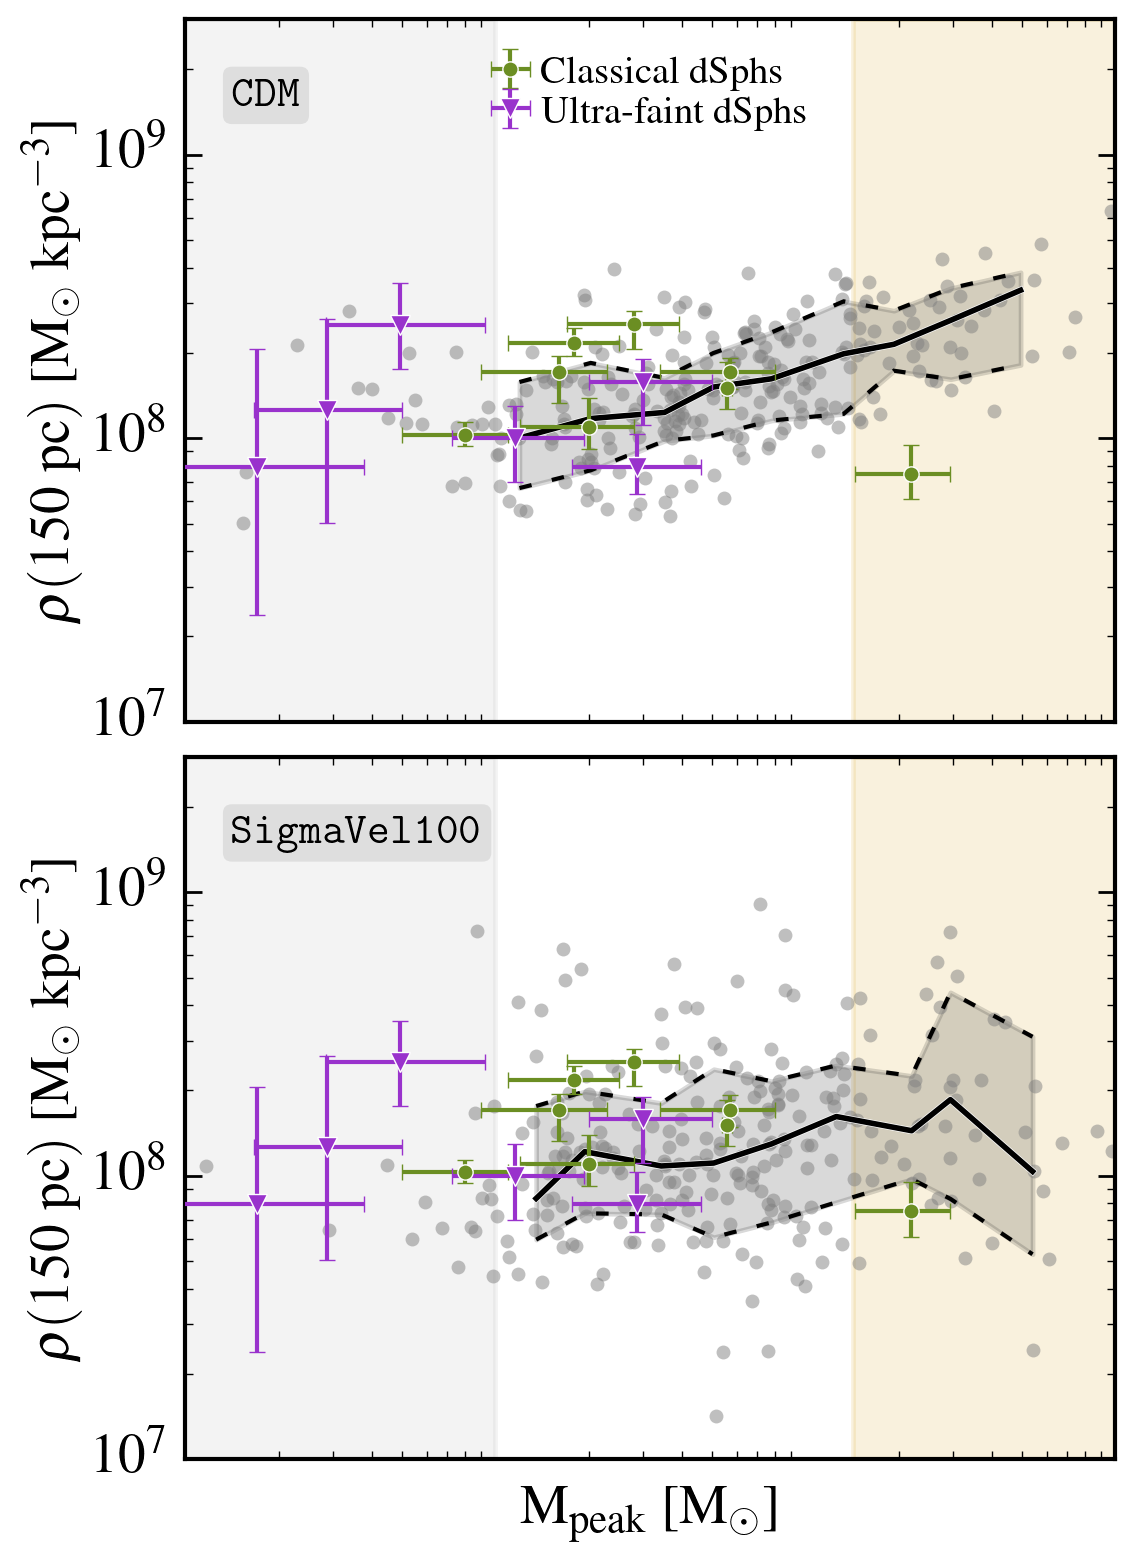

In [5]:
DATA_PATH = "../data/TangoSIDM/"
IDs = {
    "SigmaConstant00": "CDM",
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

fig, axs = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(6, 9), dpi=200, facecolor='white')

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    axs[i].fill_between(np.array([1e7, 1e9]), np.array([2e6, 2e6]), np.array([3e9, 3e9]), color='#b0b0b0', alpha=0.15)

    xrange = np.ones(2) * 14.28e9
    yrange = np.array([2e6, 3e9])
    # axs[i].plot(xrange, yrange, '--',lw=2, color='goldenrod')
    axs[i].fill_between(np.array([14.28e9, 1e11]), np.array([2e6, 2e6]), np.array([3e9, 3e9]), color='goldenrod', alpha=0.15)

    # Add simulations points
    rp, rho150, M200 = [], [], []
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:8]:
                data_subhalo = file[f'{subhalo_idx}']

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])

                z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']
                mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]
                
                M200 = np.append(M200, mass_peak)

    axs[i].plot(M200, rho150, 'o', ms=5, color='grey', markeredgecolor='none', alpha=0.5)
    m_bins = np.arange(9, 11.2, 0.2)
    m_bins = 10**m_bins
    select = np.where(M200>=1e9)[0]
    plot_median_relation(axs[i], m_bins, M200[select], rho150[select], color='black')

    axs[i].errorbar(M200_R19[0,:], rho_150pc_K19[0,:], yerr=rho_150pc_K19[1:,:], xerr=M200_R19[1:,:],
                 marker='o', markersize=5.5, markeredgecolor="white", ls='none', lw=1.5, c='olivedrab',
                 label='Classical dSphs', zorder=1000)

    axs[i].errorbar(M200_H19[0,:], rho150pc_H19[0,:], yerr=rho150pc_H19[1:,:], xerr=M200_H19[1:,:],
             marker='v', markersize=7, markeredgecolor="white", ls='none', lw=1.5, c='darkorchid',
             label='Ultra-faint dSphs', zorder=1000)

    # M200_And = np.zeros(3)
    # M200_And[0] = 2.8e9
    # M200_And[1] = 2.8e9-1.5e9
    # M200_And[2] = 4e9-2.8e9

    # rho_150pc_And = np.zeros(3)
    # rho_150pc_And[0] = 0.25e8
    # rho_150pc_And[1] = 0.25e8-0.15e8
    # rho_150pc_And[2] = 0.3e8-0.25e8
    
    # axs.errorbar(M200_And[0], rho_150pc_And[0], yerr=[[rho_150pc_And[1]],[rho_150pc_And[2]]], 
    #              xerr=[[M200_And[1]],[M200_And[2]]],
    #              marker='*', markersize=10, markeredgecolor="white", ls='none', lw=1.5, c='pink',
    #              label='Collins et al. (2021)', zorder=1000)

    # M200_And[0] = 1.1e9
    # M200_And[1] = 1.1e9-6e8
    # M200_And[2] = 1.7e9-1.1e9

    # rho_150pc_And[0] = 0.3e8
    # rho_150pc_And[1] = 0.3e8-0.1e8
    # rho_150pc_And[2] = 0.45e8-0.3e8
    
    # axs.errorbar(M200_And[0], rho_150pc_And[0], yerr=[[rho_150pc_And[1]],[rho_150pc_And[2]]], 
    #              xerr=[[M200_And[1]],[M200_And[2]]],
    #              marker='>', markersize=8, markeredgecolor="white", ls='none', lw=1.5, c='purple',
    #              label='Charles et al. (2022)', zorder=1000)

    
    props = dict(facecolor='silver', edgecolor='none', alpha=0.4, boxstyle='round, pad=0.2')
    axs[i].text(0.05, 0.92, fr'$\texttt{{{id_name}}}$', transform=axs[i].transAxes, fontsize=16, verticalalignment='top', bbox=props, zorder=1000)
                    
    axs[i].set_xlim([1e8, 1e11])
    axs[i].set_ylim([1e7, 3e9])
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylabel(r"$\rho(150\ \mathrm{pc})$ [M$_{\odot}$ kpc$^{-3}$]")    

    ####
    file.close()
    
axs[0].legend(loc=[0.32,0.82],labelspacing=0.1, handlelength=0.6, handletextpad=0.5, 
                   frameon=False, fontsize=14, ncol=1, columnspacing=1, numpoints=1)
axs[0].set_xticks([])
axs[1].set_xlabel(r"$\mathrm{M_{peak}}$ [M$_{\odot}$]")
plt.subplots_adjust(hspace=0.05)

plt.savefig('figures/Density_Mpeak.png', dpi=300, transparent=True)
plt.show()

## Checks

In [8]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}


obs_data_mass = np.log10(M200_R19[0,:])
obs_data_rho = np.log10(rho_150pc_K19[0,:])
spearman_obs0 = stats.spearmanr(obs_data_mass, obs_data_rho)

select = np.where(M200_R19[0,:]<1e10)[0] # Removing Fornax ...
obs_data_mass = np.log10(M200_R19[0,select])
obs_data_rho = np.log10(rho_150pc_K19[0,select])
spearman_obs1 = stats.spearmanr(obs_data_mass, obs_data_rho)

select = np.where(M200_H19[0,:] > 1e9)[0]
obs_data_mass = np.append(obs_data_mass, np.log10(M200_H19[0,select]))
obs_data_rho = np.append(obs_data_rho, np.log10(rho150pc_H19[0,select]))
spearman_obs2 = stats.spearmanr(obs_data_mass, obs_data_rho)

print('Obs (only Read + Fornax)',spearman_obs0)
print('Obs (only Read)',spearman_obs1)
print('Obs (Read+Hayashi)',spearman_obs2)

spearman_cdm = []
spearman_sidm = []

spearman_cdm_samplecut = []
spearman_sidm_samplecut = []

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    rp, rho150, M200 = [], [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            # Get satellites of MW halo
            #rp, rho150, M200 = [], [], []
            for subhalo_idx in subhalo_idxs[:8]:
                data_subhalo = file[f'{subhalo_idx}']

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])

                z_accr_type_idx, accretion = data_subhalo['tree_data']['accretion']
                mass_peak = data_subhalo['tree_data']['bound_mass_dm'][int(z_accr_type_idx)]
                M200 = np.append(M200, mass_peak)
        else: continue

        sim_data_mass = np.log10(M200)
        sim_data_rho = np.log10(rho150)
    
        if i == 0:
            _spearman_cdm = stats.spearmanr(sim_data_mass, sim_data_rho)
            spearman_cdm = np.append(spearman_cdm,_spearman_cdm[0])
            print(id_name,'MW',idx,_spearman_cdm)
        if i == 1:
            _spearman_sidm = stats.spearmanr(sim_data_mass, sim_data_rho)
            spearman_sidm = np.append(spearman_sidm,_spearman_sidm[0])
            print(id_name,'MW',idx,_spearman_sidm)

    
        select = np.where((M200<=1.5e10) & (M200>=1e9))[0]
        sim_data_mass = np.log10(M200[select])
        sim_data_rho = np.log10(rho150[select])
    
        if i == 0:
            _spearman_cdm = stats.spearmanr(sim_data_mass, sim_data_rho)
            spearman_cdm_samplecut = np.append(spearman_cdm_samplecut,_spearman_cdm[0])
            print(id_name,'MW',idx,_spearman_cdm)
        if i == 1:
            _spearman_sidm = stats.spearmanr(sim_data_mass, sim_data_rho)
            spearman_sidm_samplecut = np.append(spearman_sidm_samplecut,_spearman_sidm[0])
            print(id_name,'MW',idx,_spearman_sidm)

Obs (only Read + Fornax) SignificanceResult(statistic=0.03592878785739777, pvalue=0.932691474909088)
Obs (only Read) SignificanceResult(statistic=0.30631873731649006, pvalue=0.5040270086665881)
Obs (Read+Hayashi) SignificanceResult(statistic=0.0665500144921429, pvalue=0.8371878544641639)
CDM MW 15 SignificanceResult(statistic=0.6904761904761906, pvalue=0.057990318164572716)
CDM MW 15 SignificanceResult(statistic=-0.19999999999999998, pvalue=0.747060078104662)
CDM MW 20 SignificanceResult(statistic=0.5764705882352941, pvalue=0.01941514038653157)
CDM MW 20 SignificanceResult(statistic=-0.1272727272727273, pvalue=0.7092146257733047)
CDM MW 25 SignificanceResult(statistic=0.7443478260869565, pvalue=3.0376709499119458e-05)
CDM MW 25 SignificanceResult(statistic=0.17362637362637365, pvalue=0.5527669411422413)
CDM MW 26 SignificanceResult(statistic=0.6502932551319648, pvalue=5.606215527056128e-05)
CDM MW 26 SignificanceResult(statistic=-0.014705882352941175, pvalue=0.956891924031642)
CDM MW 2

In [9]:
fraction = np.where(spearman_sidm > 0.3)[0]
med = np.median(spearman_sidm)
err1 = med - np.percentile(spearman_sidm,16)
err2 = np.percentile(spearman_sidm,84) - med
print('sidm',len(fraction)/len(spearman_sidm),med,err1,err2)

fraction = np.where(spearman_sidm_samplecut > 0.3)[0]
med = np.median(spearman_sidm_samplecut)
err1 = med - np.percentile(spearman_sidm_samplecut,16)
err2 = np.percentile(spearman_sidm_samplecut,84) - med
print('sidm (sample cut)',len(fraction)/len(spearman_sidm_samplecut),med,err1,err2)

fraction = np.where(spearman_cdm > 0.3)[0]
med = np.median(spearman_cdm)
err1 = med - np.percentile(spearman_cdm,16)
err2 = np.percentile(spearman_cdm,84) - med
print('cdm',len(fraction)/len(spearman_cdm),med,err1,err2)
fraction = np.where(spearman_cdm > 0.5)[0]
med = np.median(spearman_cdm)
err1 = med - np.percentile(spearman_cdm,16)
err2 = np.percentile(spearman_cdm,84) - med
print('cdm',len(fraction)/len(spearman_cdm),med,err1,err2)

fraction = np.where(spearman_cdm_samplecut > 0.3)[0]
med = np.median(spearman_cdm_samplecut)
err1 = med - np.percentile(spearman_cdm_samplecut,16)
err2 = np.percentile(spearman_cdm_samplecut,84) - med
print('cdm (sample cut)',len(fraction)/len(spearman_cdm_samplecut),med,err1,err2)

sidm 0.030303030303030304 0.23743471005726188 0.03750983756927967 0.034805966920851444
sidm (sample cut) 0.030303030303030304 0.16658667622535978 0.021895669046581773 0.04910249264275643
cdm 1.0 0.569128140666419 0.029600237350919878 0.021802624745051236
cdm 0.9705882352941176 0.569128140666419 0.029600237350919878 0.021802624745051236
cdm (sample cut) 0.3235294117647059 0.2736687804194776 0.27476436516831315 0.10796464032424186


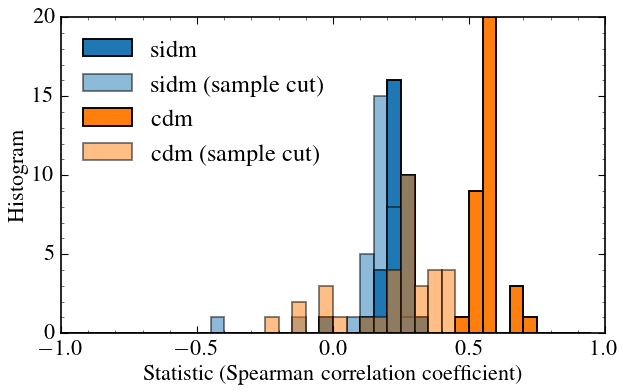

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
bins = np.arange(-1,1,0.05)
ax.hist(spearman_sidm,bins=bins,color='tab:blue',label='sidm')
ax.hist(spearman_sidm_samplecut,bins=bins,color='tab:blue',alpha=0.5,label='sidm (sample cut)')
ax.hist(spearman_cdm,bins=bins,color='tab:orange',label='cdm')
ax.hist(spearman_cdm_samplecut,bins=bins,color='tab:orange',alpha=0.5,label='cdm (sample cut)')
plt.ylabel('Histogram')
plt.xlabel('Statistic (Spearman correlation coefficient)')
plt.legend()
plt.show()